In [ ]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 25.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from sklearn.cluster import DBSCAN
from collections import Counter
import time

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
# Download the spellchecker dictionary
spell = SpellChecker()
spell.distance = 1  # Set the maximum edit distance for a word to be considered a correction
# spell.distance = 2  # Experimented with this value but decided not to proceed due to efficiency concerns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

def clean_text(text):
    # Clean and preprocess the text

    # Get the default stop words set
    stop_words = set(stopwords.words('english'))
    # Define a list of additional stop words
    additional_stop_words = ["amp", "rt", "via"]
    # Update the stop words set with the additional stop words list
    stop_words.update(additional_stop_words)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    corrected_tokens = [spell.correction(word) for word in tokens]
    corrected_tokens = [word for word in tokens if word.isalpha()]
    corrected_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(corrected_tokens)

def vectorize_text(df):
    # Vectorize the cleaned text using TF-IDF
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(df['Cleaned_Text'])
    return X, vectorizer

def perform_kmeans(X, num_clusters=5):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    return cluster_labels, kmeans

# Experimented with DBScan Clustering but decided not to proceed due to efficiency concerns
def perform_dbscan(X, eps=0.5, min_samples=5):
    # Reduce dimensionality for efficiency
    svd = TruncatedSVD(n_components=50, random_state=42)
    X_svd = svd.fit_transform(X)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X_svd)
    return cluster_labels, dbscan

def visualize_clusters(X_svd, cluster_labels):
    # Visualize clusters in 2D using Truncated SVD
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=cluster_labels, cmap='viridis')
    plt.title('Clusters Visualization (2D)')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.colorbar(scatter, label='Cluster Labels')
    plt.show()

def generate_wordclouds(df, vectorizer, num_clusters=5, terms_per_cluster=5):
    # Generate word clouds for each cluster
    for cluster_label in range(num_clusters):
        cluster_data = df[df['Cluster_Labels'] == cluster_label]
        words_in_cluster = ' '.join(cluster_data['Cleaned_Text'])

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_in_cluster)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {cluster_label}')
        plt.axis('off')
        plt.show()

def print_common_terms(terms, order_centroids, num_clusters=5, terms_per_cluster=25):
    # Describe important terms in each cluster
    for i in range(num_clusters):
        print(f'\nCluster {i} - Important Terms:')
        for j in range(terms_per_cluster):
            print(f'- {terms[order_centroids[i, j]]}')

def print_common_terms_dbscan(df, terms, cluster_labels, num_clusters=5, top_terms=25):
    # Print common terms within each cluster
    for cluster_label in range(num_clusters):
        print(f'\nCluster {cluster_label} - Common Terms:')
        cluster_indices = df.index[df['Cluster_Labels'] == cluster_label].tolist()

        # Combine all cleaned text within the cluster
        cluster_text = ' '.join(df['Cleaned_Text'][cluster_indices])

        # Tokenize and count term frequencies
        cluster_tokens = word_tokenize(cluster_text)
        term_freq = Counter(cluster_tokens)

        # Print the most common terms
        for term, freq in term_freq.most_common(top_terms):
            print(f'- {term}: {freq} occurrences')

# Function to describe the main topic of each cluster
def describe_topic(cluster_label):
    return cluster_labels_mapping.get(cluster_label, 'Unknown Topic')

# Function to suggest user accounts based on the identified topics
def suggest_cluster_name(important_terms):
    # Your logic to suggest a name based on important terms
    # Example: If 'apple' or 'aapl' is present, suggest 'Financial Markets and Stocks'
    if any(term in important_terms for term in ['apple', 'aapl']):
        return 'Financial Markets and Stocks'
    # Example: If 'covid' or 'coronavirus' is present, suggest 'Public Health and Pandemic Updates'
    elif any(term in important_terms for term in ['covid', 'coronavirus']):
        return 'Public Health and Pandemic Updates'
    # Example: If 'politics' or 'trump' is present, suggest 'Political Affairs and News'
    elif any(term in important_terms for term in ['politics', 'trump']):
        return 'Political Affairs and News'
    # Example: If 'worldcup' or 'fifa' is present, suggest 'Global Football Events'
    elif any(term in important_terms for term in ['worldcup', 'fifa']):
        return 'Global Football Events'
    # Example: If 'tech' or 'google' is present, suggest 'Technology Trends and Innovations'
    elif any(term in important_terms for term in ['tech', 'google']):
        return 'Technology Trends and Innovations'
    # Add more conditions as needed
    else:
        return 'Unknown Cluster'


# Function to apply topic description and user account suggestions to the DataFrame
def apply_topic_suggestions(df):
    df['Topic_Description'] = df['Cluster_Labels'].apply(describe_topic)
    df['Suggested_Accounts'] = df['Topic_Description'].apply(suggest_accounts)
    return df[['Cleaned_Text', 'Cluster_Labels', 'Topic_Description', 'Suggested_Accounts']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def train_subtopic_models(df, major_topic_column='Topic_Description', num_clusters=5):
    # Create a dictionary to store subtopic models and related information
    subtopic_models = {}

    # Iterate over major topics
    for major_topic in df[major_topic_column].unique():
        # Create a subset DataFrame for the current major topic
        major_topic_subset = df[df[major_topic_column] == major_topic]

        # Vectorize text for the current major topic subset
        X_major_topic, vectorizer_major_topic = vectorize_text(major_topic_subset)

        # Perform KMeans clustering on the major topic subset
        cluster_labels_major_topic, kmeans_major_topic = perform_kmeans(X_major_topic, num_clusters)

        # Add cluster labels to the major topic subset DataFrame
        major_topic_subset['Subtopic_Labels'] = cluster_labels_major_topic

        # Store subtopic models and related information in the dictionary
        subtopic_models[major_topic] = {
            'vectorizer': vectorizer_major_topic,
            'kmeans': kmeans_major_topic,
            'subset_df': major_topic_subset
        }

    return subtopic_models

def generate_subtopic_labels(subtopic_models):
    # Generate subtopic labels based on prominent terms in each subtopic cluster
    subtopic_labels = {}

    for major_topic, model_info in subtopic_models.items():
        # Get important terms for each subtopic cluster
        terms_subtopic = model_info['vectorizer'].get_feature_names_out()
        order_centroids_subtopic = model_info['kmeans'].cluster_centers_.argsort()[:, ::-1]

        # Get the top term for each subtopic cluster
        top_terms_subtopic = [terms_subtopic[order_centroids_subtopic[i, 0]] for i in range(len(order_centroids_subtopic))]

        # Store subtopic labels in the dictionary
        subtopic_labels[major_topic] = top_terms_subtopic

    return subtopic_labels

def analyze_subtopics(subtopic_models, subtopic_labels):
    # Analyze identified subtopics
    for major_topic, model_info in subtopic_models.items():
        print(f"\nMajor Topic: {major_topic}")
        print("Top Terms in Subtopics:")
        for i, label in enumerate(subtopic_labels[major_topic]):
            print(f"Subtopic {i}: {label}")
            # Add further analysis if needed


def evaluate_subtopic_models(subtopic_models):
    # Evaluate subtopic models using silhouette score
    for major_topic, model_info in subtopic_models.items():
        X_subtopic = model_info['subset_df'].drop(columns=['Subtopic_Labels'])

        # Calculate silhouette score for subtopic clusters
        silhouette_avg = silhouette_score(X_subtopic, model_info['subset_df']['Subtopic_Labels'])
        print(f"\nEvaluation for Major Topic '{major_topic}':")
        print(f"Silhouette Score for Subtopic Clusters: {silhouette_avg}")

def visualize_subtopic_clusters(X_svd, subtopic_labels, major_topic):
    # Visualize subtopic clusters in 2D using Truncated SVD
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_svd[:, 0], X_svd[:, 1], c=subtopic_labels[major_topic], cmap='viridis')
    plt.title(f'Subtopic Clusters Visualization for Major Topic "{major_topic}" (2D)')
    plt.xlabel('SVD Component 1')
    plt.ylabel('SVD Component 2')
    plt.colorbar(scatter, label='Subtopic Labels')
    plt.show()

def generate_subtopic_wordclouds(df, vectorizer, subtopic_models, major_topic, terms_per_subtopic=10):
    # Generate word clouds for each subtopic within a major topic
    model_info = subtopic_models[major_topic]
    terms_subtopic = model_info['vectorizer'].get_feature_names_out()
    order_centroids_subtopic = model_info['kmeans'].cluster_centers_.argsort()[:, ::-1]

    for subtopic_label in range(len(order_centroids_subtopic)):
        terms_in_subtopic = [terms_subtopic[order_centroids_subtopic[subtopic_label, j]] for j in range(terms_per_subtopic)]
        words_in_subtopic = ' '.join(terms_in_subtopic)

        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_in_subtopic)

        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Subtopic {subtopic_label} in Major Topic "{major_topic}"')
        plt.axis('off')
        plt.show()



In [ ]:
import time

# Specify the path to your Excel file
file_path = "/content/drive/My Drive/4404MLProject/Data.csv"

# Read INPUT FILE
start_time = time.time()
df = pd.read_csv(file_path,header=None , names=['Tweet_Text'])
print(f"Time taken to read data: {time.time() - start_time:.2f} seconds")

# Clean and preprocess text
start_time = time.time()
df['Cleaned_Text'] = df['Tweet_Text'].apply(clean_text)
df['Cleaned_Text'] = df['Cleaned_Text'].fillna('')
print(f"Time taken to clean and preprocess text: {time.time() - start_time:.2f} seconds")

# Save the DataFrame to an Excel file
output_file_path = "/content/drive/My Drive/4404MLProject/Cleaned_Data.csv"
df.to_csv(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path}")


In [ ]:
# # IN ORDER TO SKIP THE PREPROCESSING AND IMPORTING CLEANED_DATA DIRECTLY, UNCOMMENT THE BELOW CODE
# Specify the path to your Excel file
file_path = "/content/drive/My Drive/4404MLProject/Cleaned_Data.csv"

# Read data
start_time = time.time()
df = pd.read_csv(file_path,header=None, names=['Tweet_Text', 'Cleaned_Text'])
df['Cleaned_Text'] = df['Cleaned_Text'].fillna('')

print(f"Time taken to read data: {time.time() - start_time:.2f} seconds")

Time taken to read data: 4.48 seconds


In [ ]:
# Vectorize text
start_time = time.time()
X, vectorizer = vectorize_text(df)
print(f"Time taken to vectorize text: {time.time() - start_time:.2f} seconds")

# Perform KMeans clustering
start_time = time.time()
num_clusters = 5
cluster_labels, kmeans = perform_kmeans(X, num_clusters)
print(f"Time taken for KMeans clustering: {time.time() - start_time:.2f} seconds")

# Dimensionality reduction for visualization
start_time = time.time()
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X)
print(f"Time taken for dimensionality reduction: {time.time() - start_time:.2f} seconds")

# Add cluster labels to DataFrame
df['Cluster_Labels'] = cluster_labels

# Analyze important terms in each cluster
start_time = time.time()
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
print_common_terms(terms, order_centroids,terms_per_cluster=15)
print(f"Time taken to analyze important terms: {time.time() - start_time:.2f} seconds")

Time taken to vectorize text: 11.23 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Time taken for KMeans clustering: 4.79 seconds
Time taken for dimensionality reduction: 1.46 seconds

Cluster 0 - Important Terms:
- aapl
- apple
- fb
- goog
- googl
- earnings
- spy
- iphone
- stock
- options
- stocks
- yhoo
- lnkd
- qqq
- baba

Cluster 1 - Important Terms:
- covid
- coronavirus
- pandemic
- people
- vaccine
- us
- new
- positive
- health
- due
- testing
- deaths
- one
- need
- get

Cluster 2 - Important Terms:
- politics
- news
- us
- trump
- tsla
- amzn
- new
- people
- goog
- google
- msft
- political
- get
- like
- one

Cluster 3 - Important Terms:
- worldcup
- qatar
- cup
- fifaworldcup
- world
- ecuador
- qatarworldcup
- opening
- fifa
- goal
- offside
- football
- ceremony
- worldcupqatar
- var

Cluster 4 - Important Terms:
- cases
- covid
- new
- deaths
- total
- coronavirus
- reported
- confirmed
- india
- active
- last
- positive
- reports
- hours
- number
Time taken to analyze important terms: 0.01 seconds


In [ ]:
# DECIDED NOT TO PROCEED WITH DBSCAN CLUSTERING DUE TO ALGORITHM EFFICIENCY CONCERNS

# Perform DBScan clustering as an alternative
# start_time = time.time()
# eps = 0.5
# min_samples = 5
# cluster_labels, dbscan = perform_dbscan(X, eps=eps, min_samples=min_samples)
# print(f"Time taken for DBSCAN clustering: {time.time() - start_time:.2f} seconds")

# # Dimensionality reduction for visualization
# start_time = time.time()
# svd = TruncatedSVD(n_components=2, random_state=42)
# X_svd = svd.fit_transform(X)
# print(f"Time taken for dimensionality reduction: {time.time() - start_time:.2f} seconds")

# # Add cluster labels to DataFrame
# df['Cluster_Labels_DBScan'] = cluster_labels

# # Analyze important terms in each cluster
# start_time = time.time()
# print_common_terms_dbscan(df, terms, cluster_labels, top_terms=15)
# print(f"Time taken to analyze important terms: {time.time() - start_time:.2f} seconds")


In [ ]:
# Apply the manually selected topic descriptions and user account suggestions to the DataFrame
cluster_labels_mapping = {
    0: 'Financial Markets and Stocks',
    1: 'Public Health and Pandemic Updates',
    2: 'Political Affairs and News',
    3: 'Global Football Events',
    4: 'Technology Trends and Innovations',
}
start_time = time.time()
df = apply_topic_suggestions(df)
print(f"Time taken to apply topic suggestions: {time.time() - start_time:.2f} seconds")

# Display the DataFrame
print(df)

Time taken to apply topic suggestions: 0.79 seconds
                                             Cleaned_Text  Cluster_Labels  \
0                                            Cleaned_Text               2   
1                     apple get swype iphone crack iphone               0   
2           apple adding carrier support iphone announced               2   
3       hilarious youtube video guy duet apple siri pr...               2   
4                rim made easy switch apple iphone see ya               2   
...                                                   ...             ...   
335596  faceplantjim thanks jim low expectations get s...               2   
335597  therealfly amzn shorts lined front dick guillo...               2   
335598  led apples iphone plus phablets next big thing...               0   
335599  investors purchase high volume put options goo...               2   
335600  traders purchase large volume put options goog...               2   

                   Topi

In [ ]:
# Save the DataFrame to an Excel file
output_file_path = "/content/drive/My Drive/4404MLProject/Processed_Data.csv"
df.to_csv(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path}")

DataFrame saved to /content/drive/My Drive/4404MLProject/Processed_Data.csv


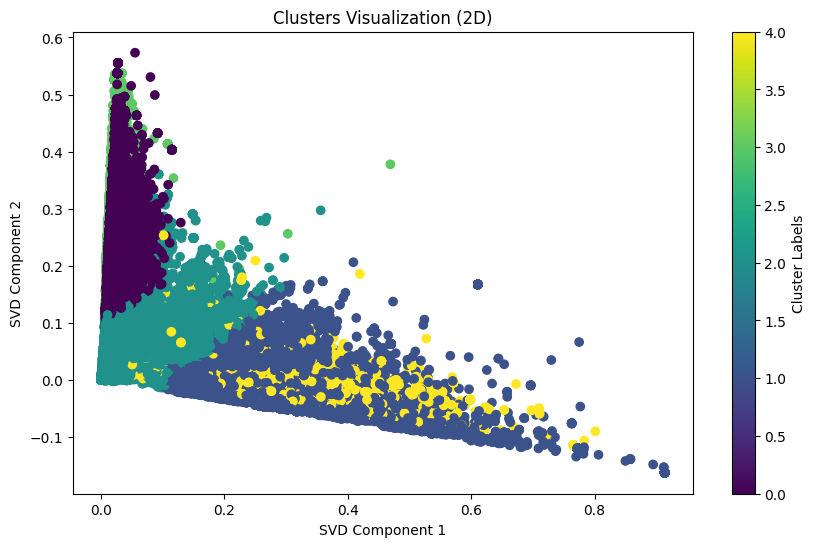

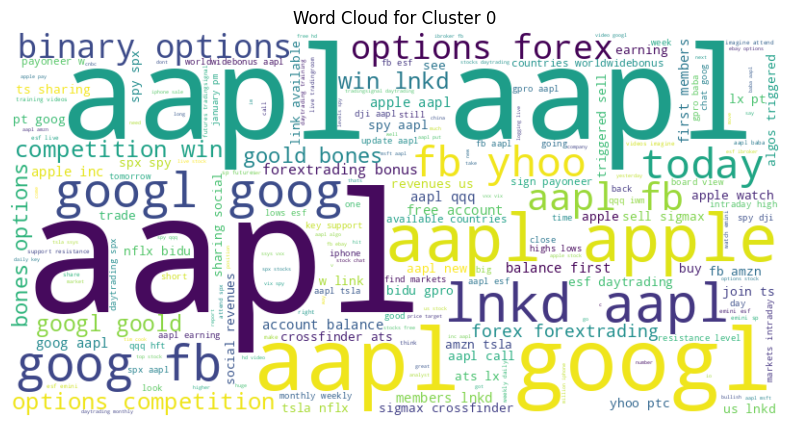

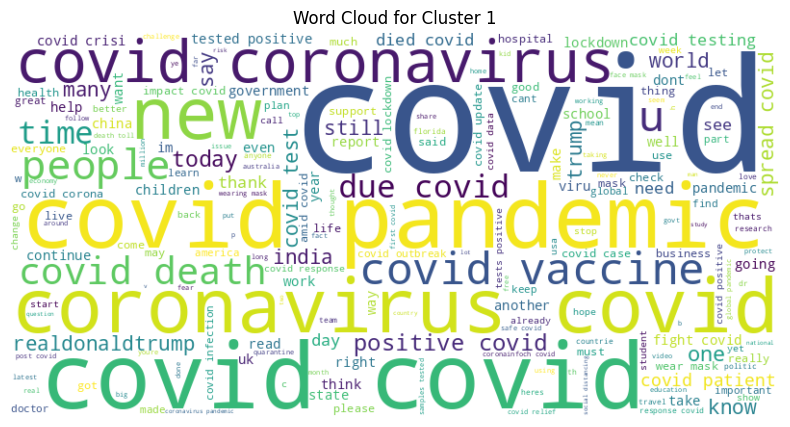

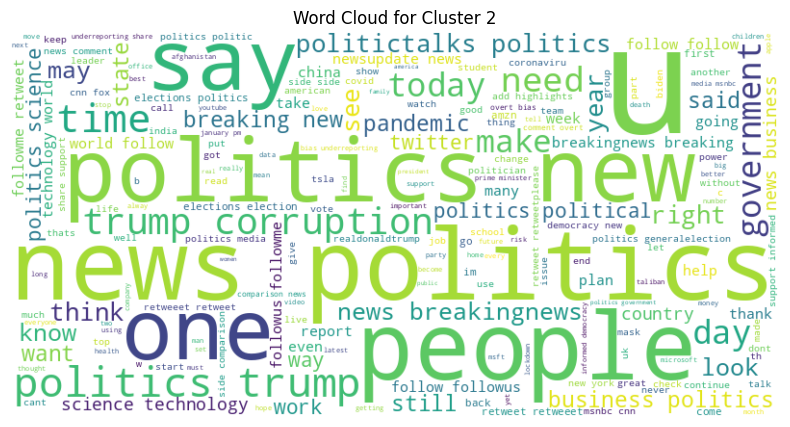

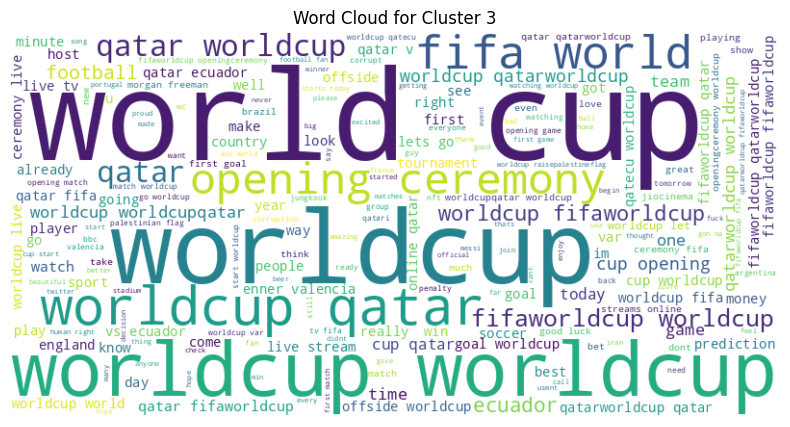

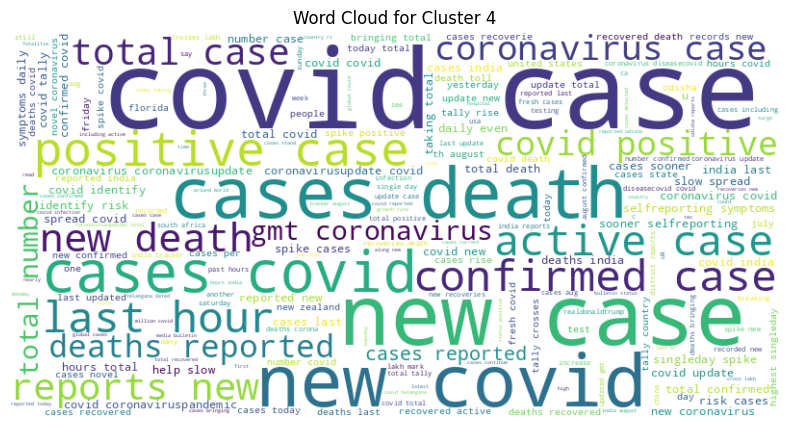

Time taken for visualizations: 49.27 seconds


In [ ]:
# VISUALIZATIONS

start_time = time.time()
# Visualize clusters
visualize_clusters(X_svd, cluster_labels)

# Generate word clouds for each cluster
generate_wordclouds(df, vectorizer)

print(f"Time taken for visualizations: {time.time() - start_time:.2f} seconds")

In [ ]:
# Print topics and number of tweets for each topic
topic_sizes = df['Topic_Description'].value_counts()
for topic, size in topic_sizes.items():
    print(f'Topic: {topic}, Number of Tweets: {size}')


Topic: Political Affairs and News, Number of Tweets: 171301
Topic: Public Health and Pandemic Updates, Number of Tweets: 94541
Topic: Financial Markets and Stocks, Number of Tweets: 32498
Topic: Global Football Events, Number of Tweets: 21068
Topic: Technology Trends and Innovations, Number of Tweets: 16193


**DECIDED NOT TO PROCEED WITH SUBCLUSTERING CLUSTERING DUE TO INCONCLUSIVE AND MIXED SUBCLUSTERS**

**Code is commented out**



In [ ]:
major_topic_column_name = 'Topic_Description'
num_clusters_subtopic = 3  # Adjust as needed

# Train subtopic models
subtopic_models = train_subtopic_models(df, major_topic_column=major_topic_column_name, num_clusters=num_clusters_subtopic)


subtopic_models: {'Political Affairs and News': {'vectorizer': TfidfVectorizer(max_features=1000), 'kmeans': KMeans(n_clusters=3, random_state=42), 'subset_df':                                              Cleaned_Text  Cluster_Labels  \
0                                            Cleaned_Text               2   
2           apple adding carrier support iphone announced               2   
3       hilarious youtube video guy duet apple siri pr...               2   
4                rim made easy switch apple iphone see ya               2   
5            realized reason got twitter ios thanks apple               2   
...                                                   ...             ...   
335595                     amazons revenue rises amzn wsj               2   
335596  faceplantjim thanks jim low expectations get s...               2   
335597  therealfly amzn shorts lined front dick guillo...               2   
335599  investors purchase high volume put options goo...            

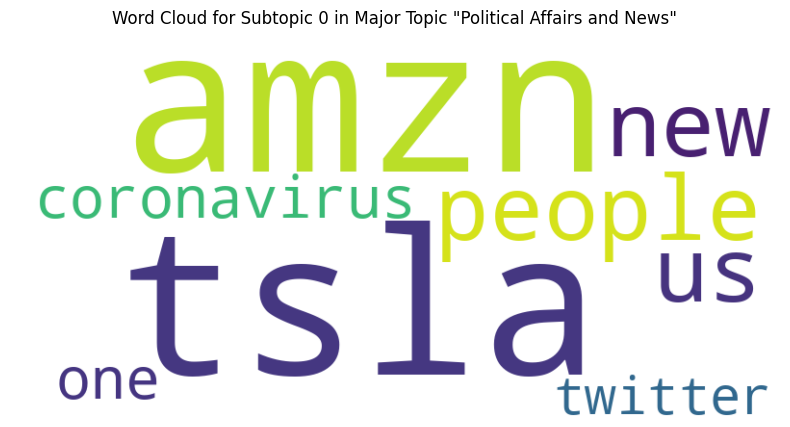

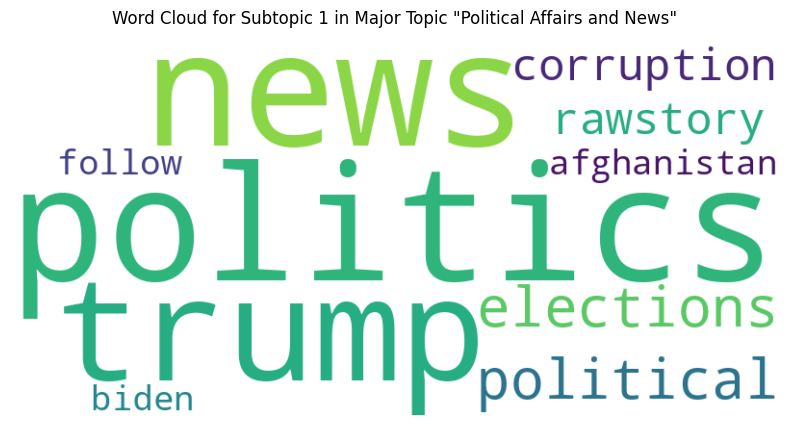

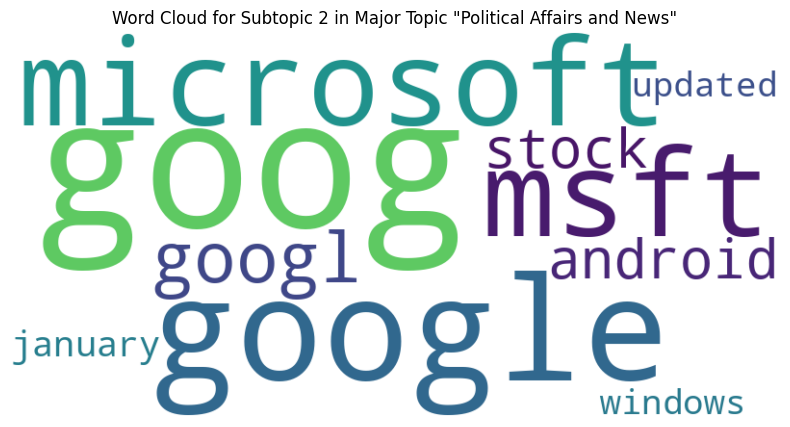

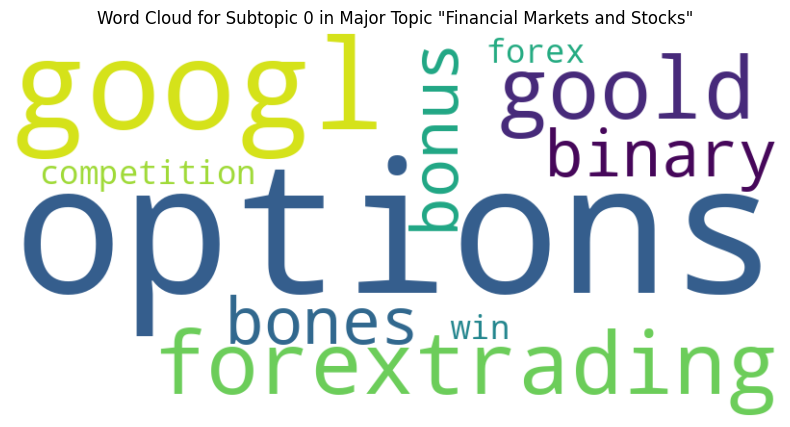

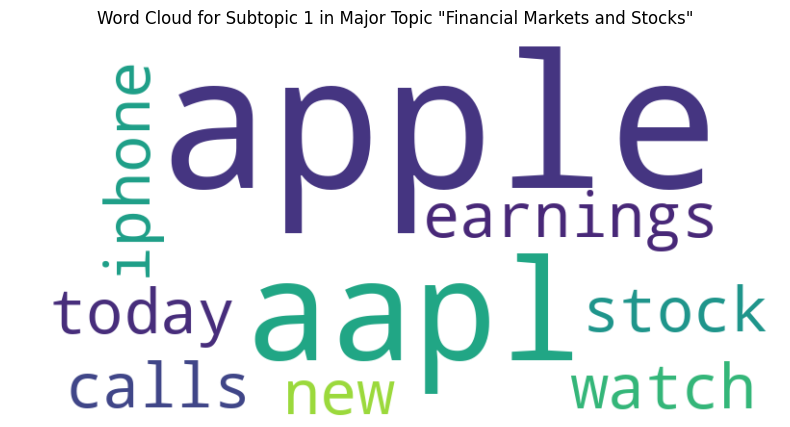

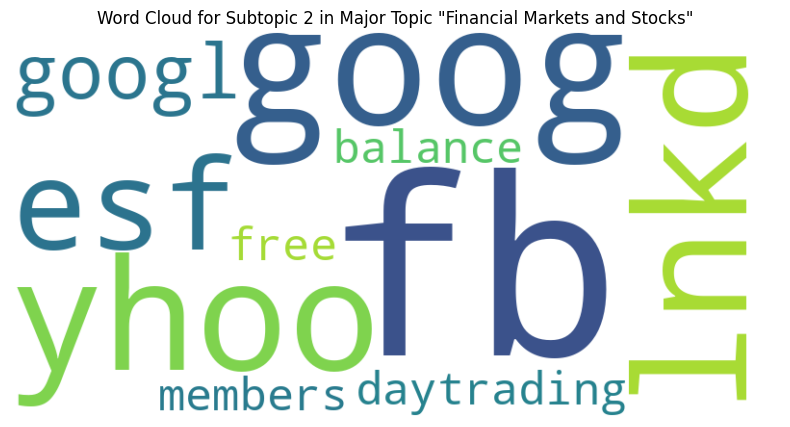

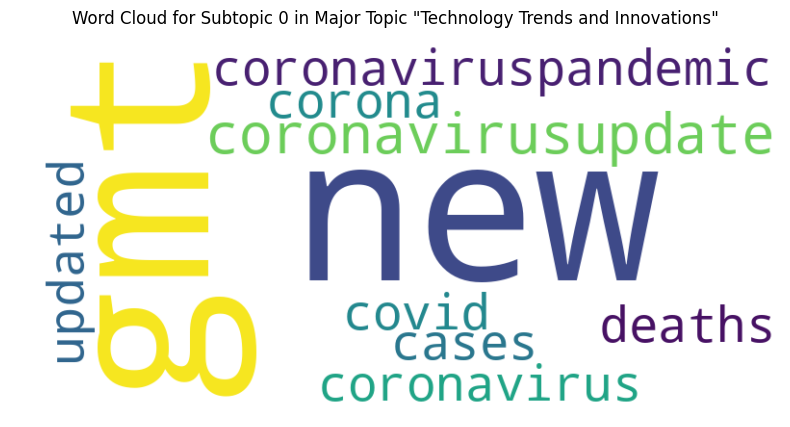

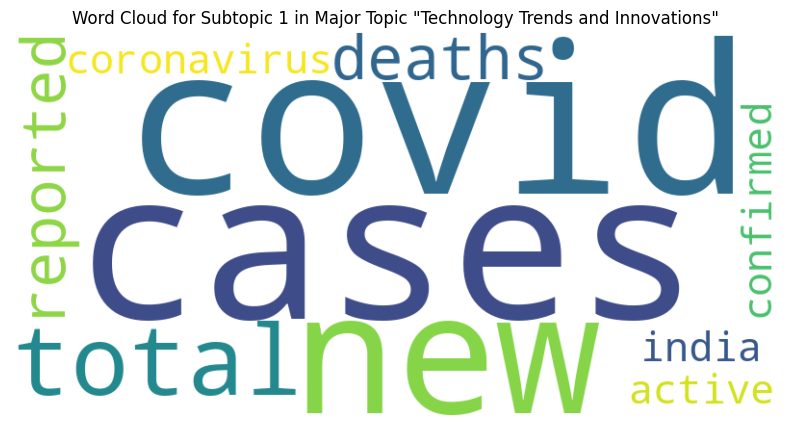

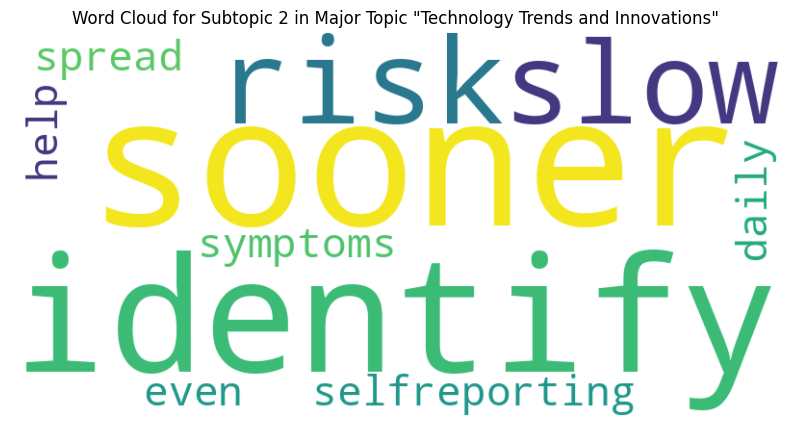

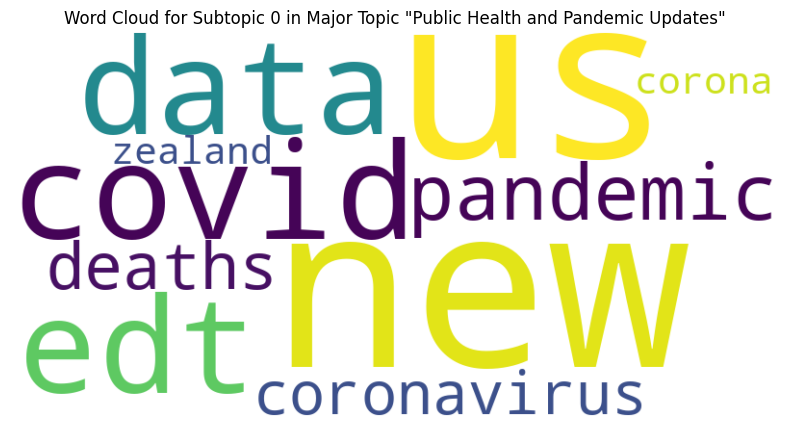

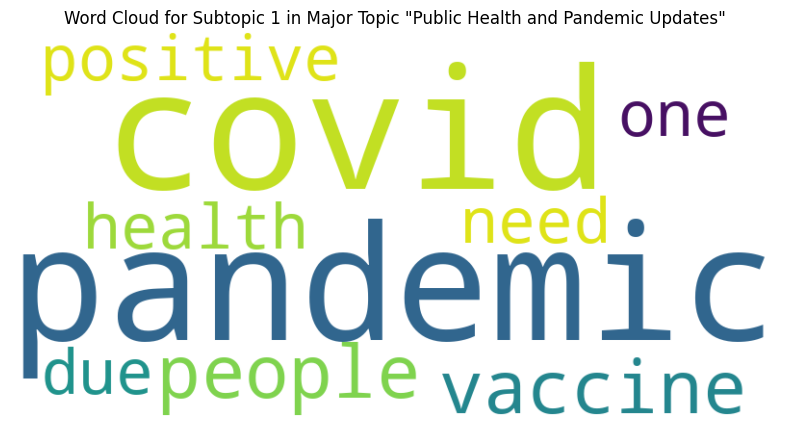

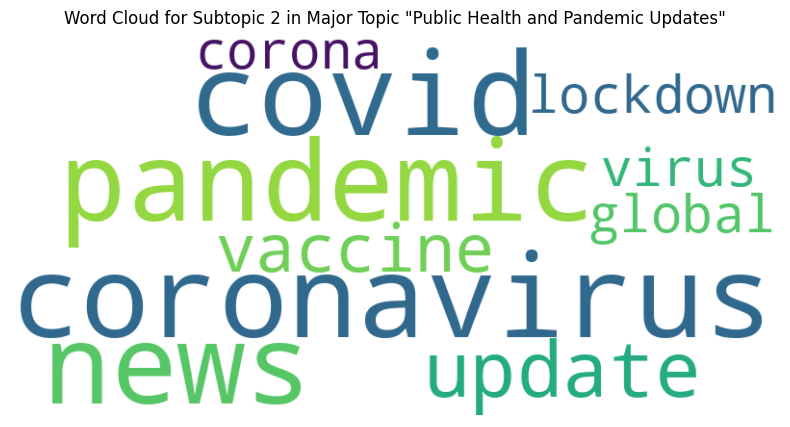

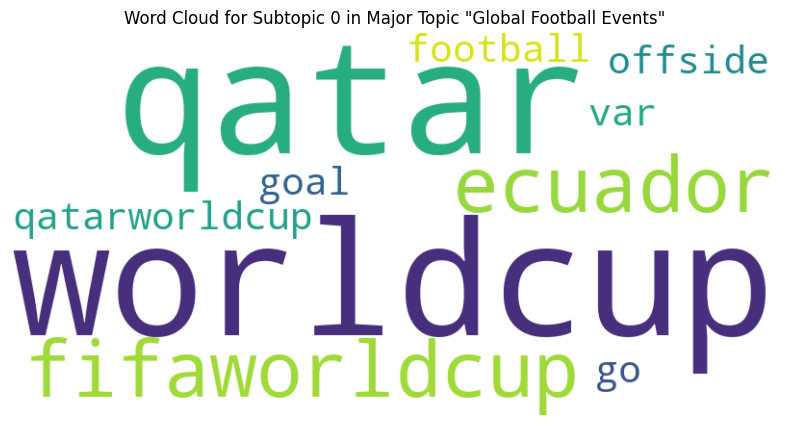

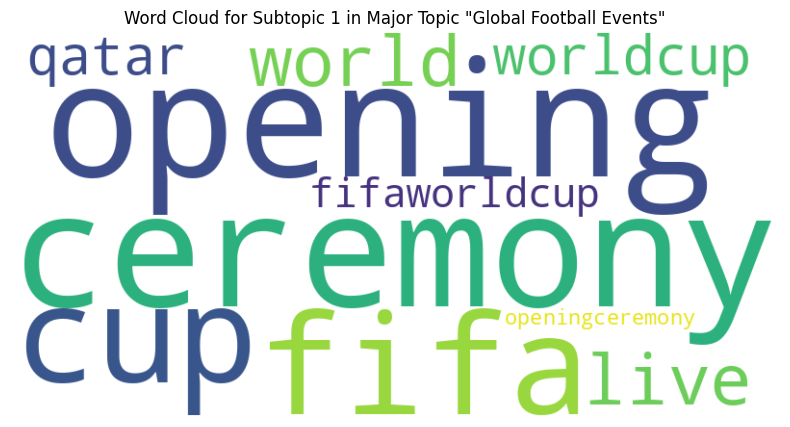

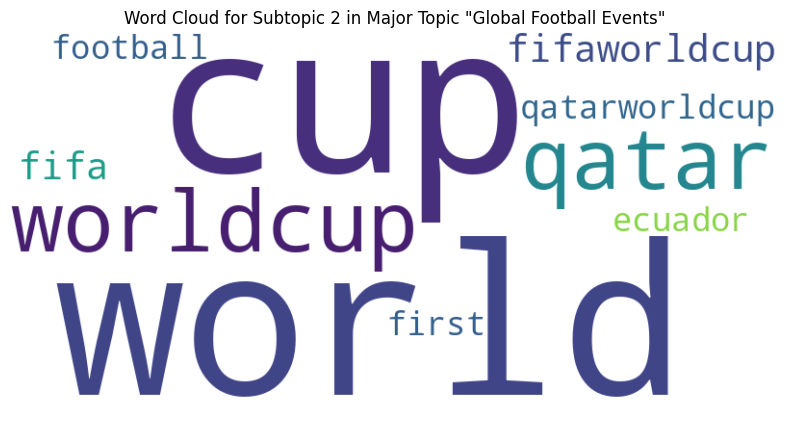

In [ ]:

print("subtopic_models:", subtopic_models)
# print("Labels shape:", model_info['subset_df']['Subtopic_Labels'].shape)

# # Evaluate subtopic models
# evaluate_subtopic_models(subtopic_models)

# Generate subtopic labels
subtopic_labels = generate_subtopic_labels(subtopic_models)

# Analyze subtopics
analyze_subtopics(subtopic_models, subtopic_labels)

# Example Usage
# Assuming df is the DataFrame containing the tweets and Major_Topic and Subtopic_Labels columns
# Also, assuming X_svd is the 2D representation of the vectors obtained using Truncated SVD

# # Visualize subtopic clusters
# for major_topic in subtopic_models.keys():
#     visualize_subtopic_clusters(X_svd, subtopic_models[major_topic]['subset_df']['Subtopic_Labels'], major_topic)

# Generate subtopic word clouds
for major_topic in subtopic_models.keys():
    generate_subtopic_wordclouds(df, vectorizer, subtopic_models, major_topic)
